In [1]:
import pandas as pd
import regex as re
import os
import warnings
import numpy as np
import keras
import tensorflow as tf
from transformers import PhobertTokenizer, TFRobertaForSequenceClassification,AutoTokenizer, TFAutoModelForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plotly.offline import iplot
import seaborn as sns
import torch

d:\Python\Python\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_path(fileName):
    
    # Kiểm tra và tạo thư mục "data" nếu nó chưa tồn tại
    data_folder = 'data'
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    # Đường dẫn đến tệp CSV
    file_path = os.path.join(data_folder, fileName)

    return file_path

In [3]:
file_path = get_path('data_processed.csv')

In [4]:
df = pd.read_csv(file_path, dtype={'content': str, 'label': str})
df.head(10)

,content,label
0,áo bao đẹp ạ,5
1,tuyệt_vời,5
2,mùi thơm bôi lên da mềm da,5
3,vải đẹp dày_dặn,5
4,hàng rất đẹp rất chi là ưng_ý,5
5,chất_lượng sản_phẩm tốt date dài,5
6,ăn_nói và thái_độ phục_vụ tốt,4
7,đóng_gói sản_phẩm chắc_chắn,5
8,tất sờn hết ca chưa dùng mà vay r,2
9,shop phục_vụ rất tốt,5


In [ ]:
df = df.drop(index=df.index[df.index >= 5000])

In [5]:
df.shape

(31432, 2)

In [6]:
df['content'] = df['content'].fillna('').astype(str)

In [7]:
# Count of text
df['count'] = df['content'].apply(lambda x: len(x.split()))
df

,content,label,count
0,áo bao đẹp ạ,5,4
1,tuyệt_vời,5,1
2,mùi thơm bôi lên da mềm da,5,7
3,vải đẹp dày_dặn,5,3
4,hàng rất đẹp rất chi là ưng_ý,5,7
...,...,...,...
31427,không đáng tiền,1,3
31428,quần rất đẹp,5,3
31429,hàng đẹp đúng giá tiền,5,5
31430,chất vải khá ổn,4,4


<Figure size 800x800 with 0 Axes>

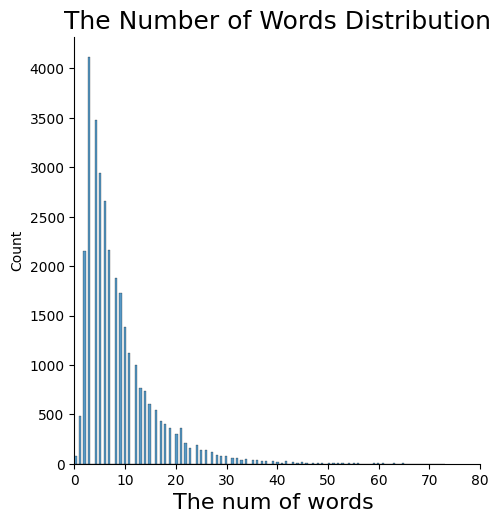

In [8]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 80)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [9]:
label_count = df['label'].value_counts()

labels = label_count.index

labels

Index(['5', '4', '3', '1', '2'], dtype='object', name='label')

In [10]:
label_count

label
5    13274
4     6802
3     4694
1     3526
2     3136
Name: count, dtype: int64

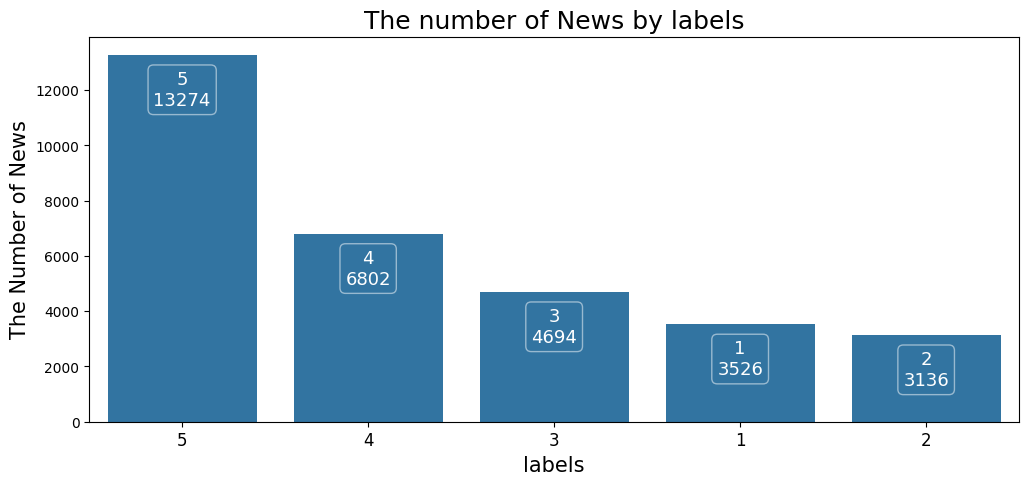

In [11]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = label_count.index, y = label_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{labels[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('labels', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by labels" , size = 18)

plt.show()

In [12]:
df['label'].unique()

array(['5', '4', '2', '3', '1'], dtype=object)

In [13]:
df['encoded_label'], _ = pd.factorize(df['label'])
# encoded_dict = {"1":1,"2":2, '3':3, "4":4,'5':5}
# df['encoded_label'] = df['label'].map(encoded_dict)

df.head(20)

,content,label,count,encoded_label
0,áo bao đẹp ạ,5,4,0
1,tuyệt_vời,5,1,0
2,mùi thơm bôi lên da mềm da,5,7,0
3,vải đẹp dày_dặn,5,3,0
4,hàng rất đẹp rất chi là ưng_ý,5,7,0
5,chất_lượng sản_phẩm tốt date dài,5,5,0
6,ăn_nói và thái_độ phục_vụ tốt,4,5,1
7,đóng_gói sản_phẩm chắc_chắn,5,3,0
8,tất sờn hết ca chưa dùng mà vay r,2,9,2
9,shop phục_vụ rất tốt,5,4,0


In [14]:
data_texts = df['content'].to_list()

# data_labels = df['encoded_label'].to_list()
data_labels = df['label'].to_list()

In [ ]:
data_labels

# Train Test SPlit

In [ ]:

# train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


# train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )

train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )

# Model Definition

In [ ]:
# Khởi tạo tokenizer của PhoBERT
tokenizer = PhobertTokenizer.from_pretrained('vinai/phobert-base', use_fast=False)

# Tokenize dữ liệu train và validate
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [ ]:
# Chuyển đổi dữ liệu đã tokenize thành định dạng TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(1000).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(64)

# Fine-tuning with the Model

In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] ="1"
# Tạo và kiểm tra các thư mục

In [ ]:
# Sử dụng PhoBERT và chỉ định số nhãn tương ứng
model = TFRobertaForSequenceClassification.from_pretrained('vinai/phobert-base', num_labels=5)

# Tạo một callback để lưu mô hình và log
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='.\\models\\model_{epoch}.keras'),
    tf.keras.callbacks.TensorBoard(log_dir='.\\models\\logs')
]


# Biên dịch mô hình với các thông số tùy chỉnh
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Hàm để thực hiện huấn luyện
def train_model():
    model.fit(train_dataset,
            epochs=5,
            callbacks=callbacks,
            validation_data=val_dataset)

# Hàm để thực hiện đánh giá mô hình
def evaluate_model():
    return model.evaluate(val_dataset)

In [ ]:
# Tắt cảnh báo TensorFlow và Deprecation
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Tắt cảnh báo về softmax cross-entropy
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Bắt đầu quá trình huấn luyện
train_model()

In [ ]:
evaluate_model()

# Using model??

In [ ]:
test_texts

In [ ]:
# Tạo từ điển ánh xạ giữa label ban đầu và label encoded
# label_to_encoded = dict(zip(df['label'], df['encoded_label']))

def predict_model(input_text):
    # Mã hóa văn bản đầu vào
    encoded_input = tokenizer.encode_plus(
        input_text,
        return_tensors='tf',
        max_length=256,  # Độ dài tối đa của chuỗi đầu vào
        truncation=True,
        padding='max_length'
    )
    # Dự đoán
    predictions = model(encoded_input)
    
    # In ra các giá trị trong mảng numpy
    logits_array = predictions['logits'].numpy()
    print(logits_array)
    
    # Trích xuất mảng logits từ đối tượng từ điển predictions
    logits = predictions['logits']
    # Chọn nhãn có xác suất cao nhất
    predicted_label_encoded = tf.argmax(logits, axis=1).numpy()[0]
    
    # Trích xuất label ban đầu từ label encoded
    predicted_label = list(label_to_encoded.keys())[predicted_label_encoded]
    
    # Hiển thị kết quả dưới dạng encoded label và label ban đầu
    result = f"encoded label: {predicted_label_encoded} - label: {predicted_label}"
    
    return result


In [ ]:
test_text = test_texts[1]

print(test_text),
predict_model(test_text)

# # Loading Pre-Trained Model

In [ ]:
def create_model():
    # Tạo mô hình mới với kiến trúc tương tự mô hình ban đầu
    model = TFRobertaForSequenceClassification.from_pretrained('vinai/phobert-base', num_labels=5)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Tạo mô hình mới
new_model = create_model()

# Khôi phục trọng số từ tệp checkpoint đã lưu
new_model.load_weights('./models/model_1.keras')


In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy = new_model.evaluate(val_dataset)
print(f"Validation loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


In [ ]:
# Tạo từ điển ánh xạ giữa label ban đầu và label encoded
# label_to_encoded = dict(zip(df['label'], df['encoded_label']))

def predict_newmodel(input_text):
    # Mã hóa văn bản đầu vào
    encoded_input = tokenizer.encode_plus(
        input_text,
        return_tensors='tf',
        max_length=256,  # Độ dài tối đa của chuỗi đầu vào
        truncation=True,
        padding='max_length'
    )
    # Dự đoán
    predictions = new_model(encoded_input)
    
    # In ra các giá trị trong mảng numpy
    logits_array = predictions['logits'].numpy()
    print(logits_array)
    
    # Trích xuất mảng logits từ đối tượng từ điển predictions
    logits = predictions['logits']
    # Chọn nhãn có xác suất cao nhất
    predicted_label_encoded = tf.argmax(logits, axis=1).numpy()[0]
    
    # Trích xuất label ban đầu từ label encoded
    predicted_label = list(label_to_encoded.keys())[predicted_label_encoded]
    
    # Hiển thị kết quả dưới dạng encoded label và label ban đầu
    result = f"encoded label: {predicted_label_encoded} - label: {predicted_label}"
    
    return result


In [ ]:
test_texts

In [ ]:
test_text = test_texts[1]

print(test_text),
predict_newmodel(test_text)

In [ ]:
file_path = get_path('data.csv')

In [ ]:
df = pd.read_csv(file_path, dtype={'content': str, 'label': str})
df

In [ ]:
label_to_encoded = dict(zip(df['label'], df['encoded_label']))
encoded_to_label = {v: k for k, v in label_to_encoded.items()}  # Đảo ngược từ điển để ánh xạ ngược

def predict_newmodel(input_text, ):
    # Mã hóa văn bản đầu vào
    encoded_input = tokenizer.encode_plus(
        input_text,
        return_tensors='tf',
        max_length=256,  # Độ dài tối đa của chuỗi đầu vào
        truncation=True,
        padding='max_length'
    )
    # Dự đoán
    predictions = new_model(encoded_input)
    
    # Trích xuất mảng logits từ đối tượng từ điển predictions
    logits = predictions['logits']
    # Chọn nhãn có xác suất cao nhất
    predicted_label_encoded = tf.argmax(logits, axis=1).numpy()[0]
    
    # Trích xuất label ban đầu từ label encoded
    predicted_label = encoded_to_label[predicted_label_encoded]
    
    return predicted_label_encoded, predicted_label

# Giả sử test_texts là danh sách các văn bản cần dự đoán
# test_texts = ["text1", "text2", "text3", ...]

# Tạo danh sách để lưu các kết quả dự đoán
contents = []
encoded_labels = []
labels = []

# Dự đoán cho từng văn bản trong test_texts
for text in test_texts:
    predicted_label_encoded, predicted_label = predict_newmodel(text)
    
    contents.append(text)
    encoded_labels.append(predicted_label_encoded)
    labels.append(predicted_label)

# Tạo DataFrame với các cột 'content', 'encoded label' và 'label'
results_df = pd.DataFrame({
    'content': contents,
    'encoded label': encoded_labels,
    'label': labels
})

# Xuất DataFrame ra file CSV nếu cần
results_df.to_csv('predicted_results.csv', index=False)

print(results_df)